# MFHT Grid Plot
plt.close('all')

In [1]:
import sqlite3
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.optimize import curve_fit

from pathlib import Path
import sys
sys.path.append('../stabilvol')
from utility import functions as utils

ROOT = Path('../')
DATABASE = '../data/processed/trapezoidal_selection/stabilvol_filtered.sqlite'

MARKETS = ["UN", "UW", "LN", "JT"]
START_LEVELS = [
    -2.0, 
    # -1.0, -0.5, 
    -0.2, -0.1, 0.1, 0.2, 
    # 0.5, 1.0, 
    2.0
    ]
DELTAS = [
    2.0, 
    # 1.0, 0.5, 
    0.2, 0.1, -0.1, -0.2, 
    # -0.5, -1.0, 
    -2.0
    ]
LEVELS = {
    (start, round(start+delta, 2)) for start in START_LEVELS for delta in DELTAS
}
LEVELS = sorted(LEVELS)

VOL_LIMIT= 0.5  # Change this will change all the pickle files, remember to re-generate them
FILTERED = True  # Change this will change all the pickle files, remember to re-generate them

FILE_DIR = ROOT / f'data/processed/trapezoidal_selection/vol0{str(VOL_LIMIT).replace(".", "")}'

len(LEVELS)

36

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

   Volatility  FHT                       start                         end  \
0    0.015084    4  2010-01-25 00:00:00.000000  2010-01-29 00:00:00.000000   
1    0.015908    3  2010-02-01 00:00:00.000000  2010-02-04 00:00:00.000000   
2    0.012530    9  2010-02-05 00:00:00.000000  2010-02-22 00:00:00.000000   
3    0.012170   17  2010-02-23 00:00:00.000000  2010-03-18 00:00:00.000000   
4    0.019449    3  2010-03-22 00:00:00.000000  2010-03-25 00:00:00.000000   

  Market  
0     UN  
1     UN  
2     UN  
3     UN  
4     UN  


<Axes: ylabel='Frequency'>

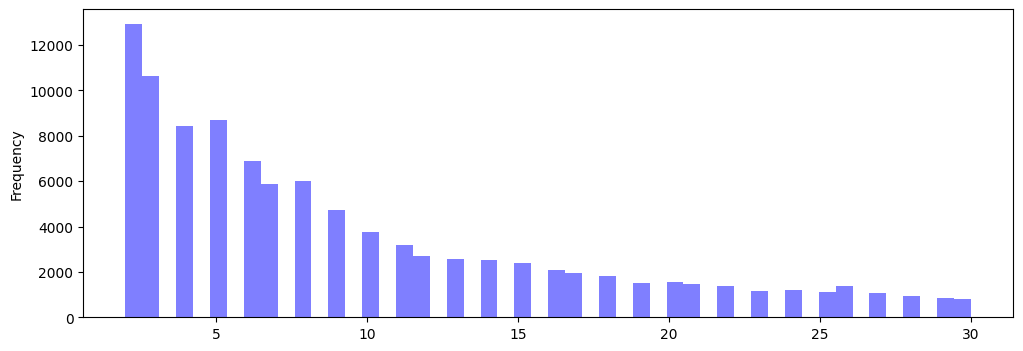

In [3]:
start_date = '2010-01-01'
end_date = '2022-07-01'
t1_string = "m0p5"
t2_string = "m1p5"
vol_limit = 0.5
market = "UN"
# Write the SQL query
query = f'''
SELECT *
FROM stabilvol_{t1_string}_{t2_string}
WHERE Volatility < {vol_limit} 
AND Market = "{market}"
AND start > "{start_date}"
AND end < "{end_date}"    
'''
df = pd.read_sql_query(query, conn)
print(df.head())
df['FHT'].plot(kind='hist', bins=50, alpha=0.5, color='blue', label='FHT', figsize=(12, 4))

In [4]:
def select_bins(df, max_n=1000):
    nbins = 50
    
    while True:
        # Use qcut to bin 'Volatility' values
        df['Bins'] = pd.qcut(df['Volatility'], nbins, duplicates='drop')
        
        # Group by the bins and calculate the mean and standard error of 'value'
        grouped = df.groupby('Bins', observed=False)['FHT'].agg(['mean', error_on_the_mean, 'size'])
        count = grouped['size'].min()
        
        if count < max_n or nbins > 1000:
            break
        else:
            nbins += 50
    return grouped, nbins

def error_on_the_mean(values):
    return np.std(values)/np.sqrt(len(values))

In [ ]:
tqdm(total)

In [69]:
def query_binned_data(market: str, t1_string: str, t2_string: str, vol_limit: float):
    grouped_data = None
    try:            
        # Write the SQL query
        query = f'''
        SELECT *
        FROM stabilvol_{t1_string}_{t2_string}
        WHERE Volatility < {vol_limit} AND Market = "{market}"
        '''
        # Load the FHT data from the database
        df = pd.read_sql_query(query, conn)
    except pd.errors.DatabaseError:
        print(f'No data for market {market} with thresholds {t1_string}-{t2_string}')
        nbins = 0
    else:
        grouped_data, nbins = select_bins(df)
    return grouped_data, nbins

def save_all_mfhts(market, save=True):
    bins_dict = {}
    pbar = tqdm(LEVELS, desc=f'Processing {market}')
    for t1, t2 in pbar:
        # Create the strings for the threshold values
        t1_string = utils.stringify_threshold(t1)
        t2_string = utils.stringify_threshold(t2)
        # Filename for the MFHT data
        filtered_string = '_filtered' if FILTERED else ''
        filename = FILE_DIR / f'mfht_{market}_{t1_string}_{t2_string}{filtered_string}.pkl'

        if filename.exists():
            grouped_data = pd.read_pickle(filename)
            nbins = len(grouped_data)
            if save:
                pbar.set_postfix_str(f'Skipping {filename}')
        else:
            # Load the FHT dataframe from the database and bin it
            grouped_data, nbins = query_binned_data(market, t1_string, t2_string, VOL_LIMIT)
            if save:
                grouped_data.to_pickle(filename)
                pbar.set_postfix_str(f'Saved to {filename}')
        
        bins_dict[(t1, t2)] = nbins  
            
    return bins_dict

In [71]:
market = "UN"
nbins_un = save_all_mfhts(market, save=True)

Processing UN: 100%|██████████| 36/36 [00:00<00:00, 883.98it/s, Skipping ..\data\processed\trapezoidal_selection\vol005\mfht_UN_2p0_4p0_filtered.pkl]


In [72]:
market = "UW"
nbins_uw = save_all_mfhts(market)

Processing UW: 100%|██████████| 36/36 [00:00<00:00, 935.81it/s, Skipping ..\data\processed\trapezoidal_selection\vol005\mfht_UW_2p0_4p0_filtered.pkl]


In [73]:
market = "LN"
nbins_ln = save_all_mfhts(market)

Processing LN: 100%|██████████| 36/36 [00:00<00:00, 967.87it/s, Skipping ..\data\processed\trapezoidal_selection\vol005\mfht_LN_2p0_4p0_filtered.pkl]


In [74]:
filename = f'../data/processed/trapezoidal_selection/vol005/mfht_LN_m0p5_m1p5.pkl'
# Load the MFHT data from the database
df = pd.read_pickle(filename)
print(df.describe())
df.head()

             mean  error_on_the_mean          size
count  183.000000         183.000000    183.000000
mean    42.759447           2.499311   1034.513661
std     34.975655           2.815519   1189.586607
min      9.330418           0.159953    941.000000
25%     15.404608           0.612621    946.000000
50%     27.948203           1.102943    947.000000
75%     61.531679           3.189050    947.000000
max    145.514256          10.266352  17039.000000


,mean,error_on_the_mean,size
Bins,,,
"(-0.001, 0.000965]",9.330418,0.159953,17039
"(0.000965, 0.00255]",49.439746,5.959101,946
"(0.00255, 0.00348]",77.322070,7.821752,947
"(0.00348, 0.00421]",103.898627,10.266352,947
"(0.00421, 0.00483]",91.228330,9.809739,946


In [75]:
market = "JT"
nbins_jt = save_all_mfhts(market)

Processing JT: 100%|██████████| 36/36 [00:00<00:00, 849.08it/s, Skipping ..\data\processed\trapezoidal_selection\vol005\mfht_JT_2p0_4p0_filtered.pkl]


In [76]:
def get_thresholds(market):
    subfolder = f"vol0{str(VOL_LIMIT).replace(".", "")}"
    for filename in FILE_DIR.glob(f"mfht_{market}*[0-9].pkl"):
        t1, t2 = str(filename).replace(".pkl", "").split('_')[-2:]
        t1 = utils.numerify_threshold(t1)
        t2 = utils.numerify_threshold(t2)
        yield (t1, t2)

# list(get_thresholds("UN"))

In [77]:

# Create a dictionary where keys are the unique first elements and values are lists of corresponding second elements
table_dict = {}

thresholds_table = [[t1, t2] for t1, t2 in sorted(get_thresholds("UN"), key=lambda x: float(x[0]), reverse=False)]
for item in thresholds_table:
    if item[0] not in table_dict:
        table_dict[item[0]] = [item[1]]
    else:
        table_dict[item[0]].append(item[1])

# Create the markdown table
markdown_table = f"| Start Threshold {'| End |'*1} |\n{'|:-------:|'*1}\n"
for key, values in table_dict.items():
    values = sorted(values, key=lambda x: float(x))
    markdown_table += f"| {key} | {'| '.join([str(s) for s in values])} |\n"

# Display the markdown table
display(Markdown(markdown_table))

| Start Threshold | End | |
|:-------:|
| -2.0 | -4.0| -3.0| -2.5| -2.2| -2.1| -1.9| -1.8| -1.5| -1.0| 0.0 |
| -1.0 | -3.0| -2.0| -1.5| -1.2| -1.1| -0.9| -0.8| -0.5| 0.0| 1.0 |
| -0.5 | -2.5| -1.5| -1.0| -0.7| -0.6| -0.4| -0.3| 0.0| 0.5| 1.5 |
| -0.2 | -2.2| -1.2| -0.7| -0.4| -0.3| -0.1| 0.0| 0.3| 0.8| 1.8 |
| -0.1 | -2.1| -1.1| -0.6| -0.3| -0.2| 0.0| 0.1| 0.4| 0.9| 1.9 |
| 0.1 | -1.9| -0.9| -0.4| -0.1| 0.0| 0.2| 0.3| 0.6| 1.1| 2.1 |
| 0.2 | -1.8| -0.8| -0.3| 0.0| 0.1| 0.3| 0.4| 0.7| 1.2| 2.2 |
| 0.5 | -1.5| -0.5| 0.0| 0.3| 0.4| 0.6| 0.7| 1.0| 1.5| 2.5 |
| 1.0 | -1.0| 0.0| 0.5| 0.8| 0.9| 1.1| 1.2| 1.5| 2.0| 3.0 |
| 2.0 | 0.0| 1.0| 1.5| 1.8| 1.9| 2.1| 2.2| 2.5| 3.0| 4.0 |


In [78]:
import matplotlib.colors as mcolors

def desaturate_color(color, factor=0.5):
    # Convert RGB to HLS
    rgb = mcolors.to_rgb(color)
    h, s, v = mcolors.rgb_to_hsv(rgb)

    # Decrease the saturation by 50% to get a desaturated color
    return mcolors.hsv_to_rgb((h, s*factor, v))

def plot_mfht_grid(markets, plotsscale='', show=False, save=False, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    root_folder = ROOT / f'data/processed/trapezoidal_selection/vol0{str(VOL_LIMIT).replace(".", "")}'
    
    if not isinstance(markets, list):
        markets = [markets]
    if plotsscale not in ['', 'log', 'logx', 'logy']:
        raise ValueError("plotsscale must be either '' or 'log'")
    
    n_rows = len(START_LEVELS)
    n_cols = len(DELTAS)
    
    # Create a grid of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 18))
    
    # Flatten the array of axes
    axs = axs.flatten()
    
    # Iterate over the indices and axes
    for i, ((t1, t2), ax) in enumerate(zip(LEVELS, axs)):
        # Create the strings for the threshold values
        t1_string = utils.stringify_threshold(t1)
        t2_string = utils.stringify_threshold(t2)
        
        for market in markets:
            # Load the dataframe from the database if it exists
            filename = f'mfht_{market}_{t1_string}_{t2_string}{"_filtered" if FILTERED else ""}.pkl'
            try:
                df = pd.read_pickle(root_folder / filename)
            except FileNotFoundError as e:
                print(f"File '{root_folder / filename}' not found")
                continue
            else:
                
                x = df.index.categories.left.values
                y = df['mean'].values
                
                y_err = df['error_on_the_mean'].values
                
                line, = ax.plot(x, y, lw=1, label=market if i==0 else "")
                
                ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
            
            if plotsscale == 'logx':
                ax.set_xscale('log')
            elif plotsscale == 'logy':
                ax.set_yscale('log')
            elif plotsscale == 'log':
                ax.set_xscale('log')
                ax.set_yscale('log')
            
            # If this is the first column, set the y-label
            if i % n_cols == 0:
                ax.set_ylabel(f"$\\theta_i = {t1}$", fontsize=16)
            # Always set the title with the final threshold value
            ax.set_title(f"$\\theta_f = {t2}$", fontsize=16)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    
    # Place a legend above the subplots
    legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.008), ncol=4)
    
    # Increase the font size
    plt.setp(legend.get_texts(), fontsize=18)
    
    # Increase the linewidth
    plt.setp(legend.get_lines(), linewidth=3)
    
    marketsname = ''.join(markets)
    if save:
        fig.savefig(f'../visualization/mfhts/{marketsname}_FHT_threshold_{plotsscale}grid.png', bbox_inches='tight')
        fig.savefig(f'../visualization/mfhts/{marketsname}_FHT_threshold_{plotsscale}grid.pdf', bbox_inches='tight', transparent=True)

    if show:
        plt.show()
    else:
        return fig
    

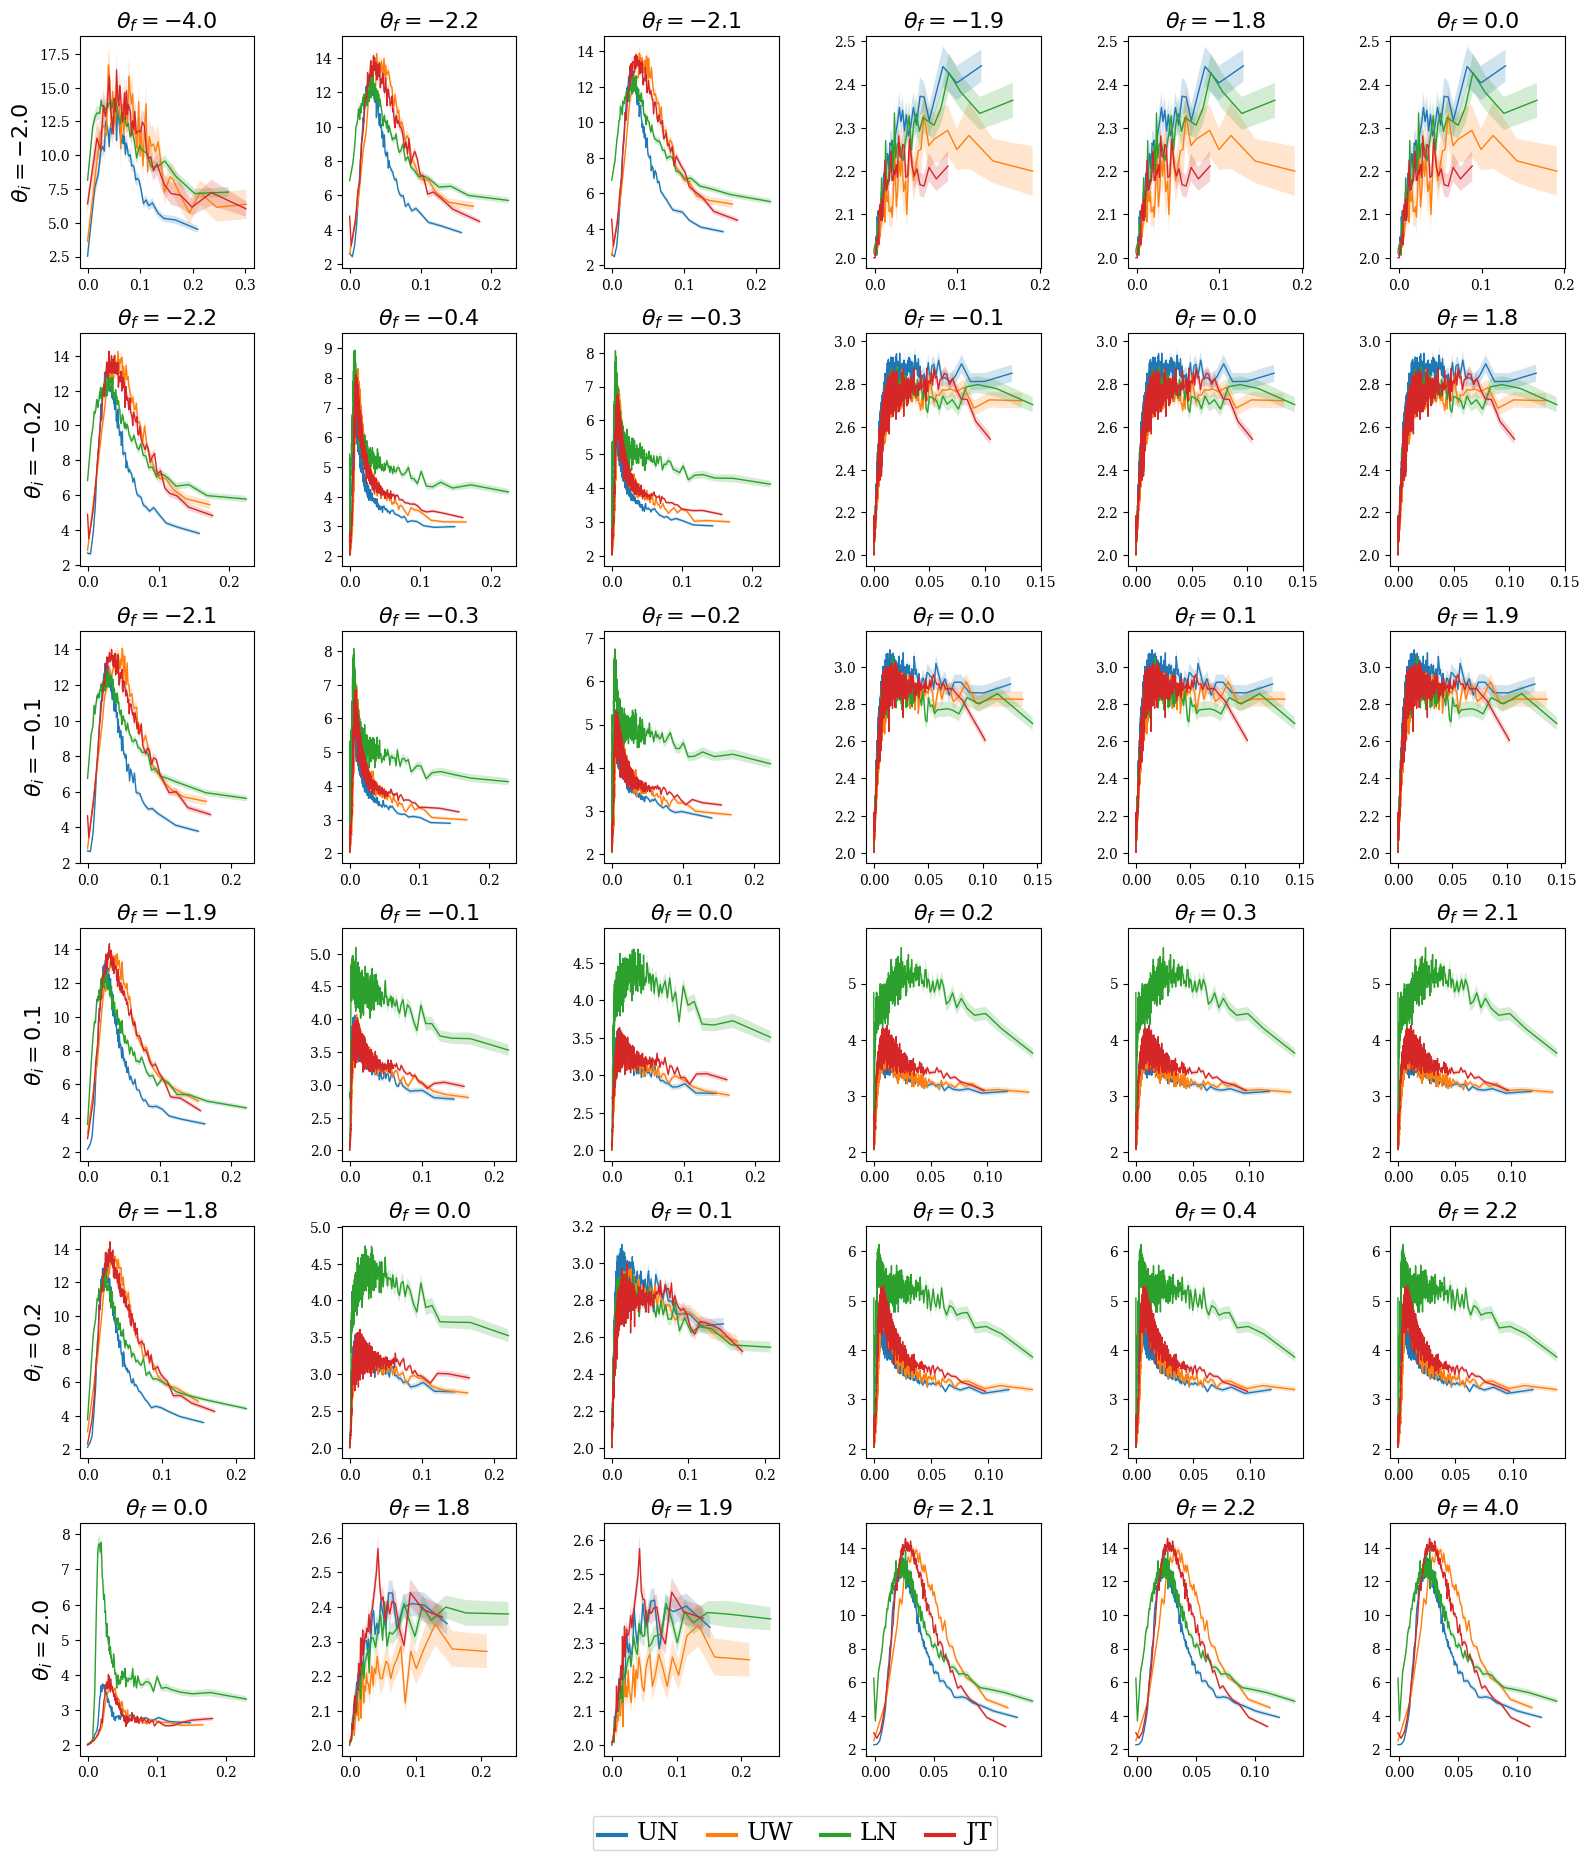

In [79]:
plt.close('all')
# plot_mfht_grid(["UN", "UW", "LN", "JT"], plotsscale='logx')
plot_mfht_grid(["UN", "UW", "LN", "JT"], plotsscale='', show=True)

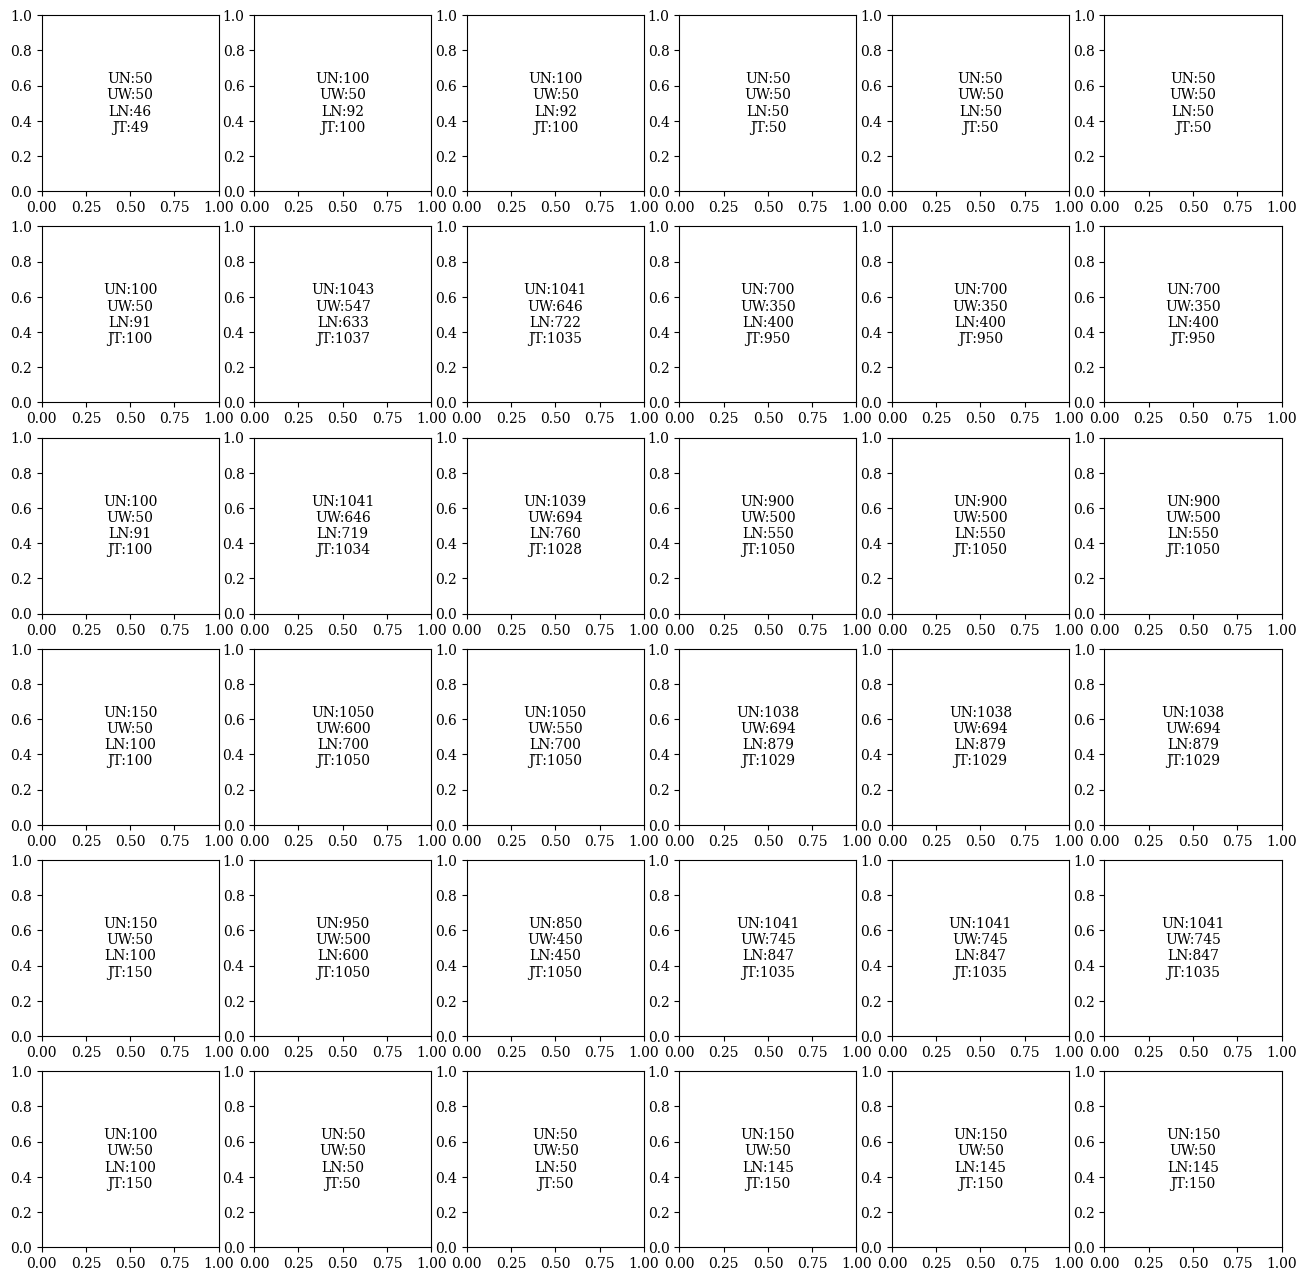

In [80]:
n_rows = len(START_LEVELS)
n_cols = len(DELTAS)

# Create a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 16))

# Flatten the array of axes
axs = axs.flatten()

for i, ((t1, t2), ax) in enumerate(zip(LEVELS, axs)):
    ax.text(0.5, 0.5, 
            f"UN:{nbins_un[(t1, t2)]}\nUW:{nbins_uw[(t1, t2)]}\nLN:{nbins_ln[(t1, t2)]}\nJT:{nbins_jt[(t1, t2)]}", 
            ha='center', va='center')

for market in ["UN", "UW", "LN", "JT"]:
    plot_mfht_grid(market)

In [83]:
def get_max_values(market):
    maxs = np.zeros((len(START_LEVELS), len(DELTAS)))
    # Iterate over the indices and axes
    for i, t1 in enumerate(START_LEVELS):
        for j, d in enumerate(DELTAS):
            # Create the strings for the threshold values
            t1_string = utils.stringify_threshold(t1)
            t2_string = utils.stringify_threshold(t1 + d)
            filename = f'mfht_{market}_{t1_string}_{t2_string}{"_filtered" if FILTERED else ""}.pkl'

            # Load the dataframe from the database if it exists
            try:
                df = pd.read_pickle(FILE_DIR / filename)
            except FileNotFoundError as e:
                print(f"File '{filename}' not found")
                continue
            else:
                maxs[i][j] = df['mean'].max()
            
    # maxs = maxs.reshape((len(START_LEVELS), len(DELTAS)))
    return maxs


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def add_annotations(ax, peaks):
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, round(peaks[i, j],1), 
                           ha="center", va="center", color="white", fontsize=9)
    return text


def plot_mfht_peaks(market, peaks, min_value, max_value, ax=None, annotations=True, latex=False):
    plt.rcParams.update({'text.usetex': latex, 'font.family': 'serif'})
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 18))
        
    ax.set_title(market, fontsize=18)
        
    im = ax.imshow(peaks, cmap='viridis', 
                   vmin=min_value, vmax=max_value,
                #    norm = mcolors.LogNorm(vmin=min_value, vmax=max_value)
                   )
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(DELTAS)), labels=reversed(DELTAS), fontsize=11, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(len(START_LEVELS)), labels=START_LEVELS, fontsize=11)
    
    # Set the grid
    ax.set_xticks(np.arange(-.5, len(DELTAS), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(START_LEVELS), 1), minor=True)
        
    # Remove the grid lines in the middle of the cells
    ax.grid(False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    
    # Loop over data dimensions and create text annotations.
    if annotations:
        annotations_text = add_annotations(ax, peaks)
                    
    if ax is None:
        plt.show()
    else:
        return ax, im

16.685714285714287 2.281456953642384


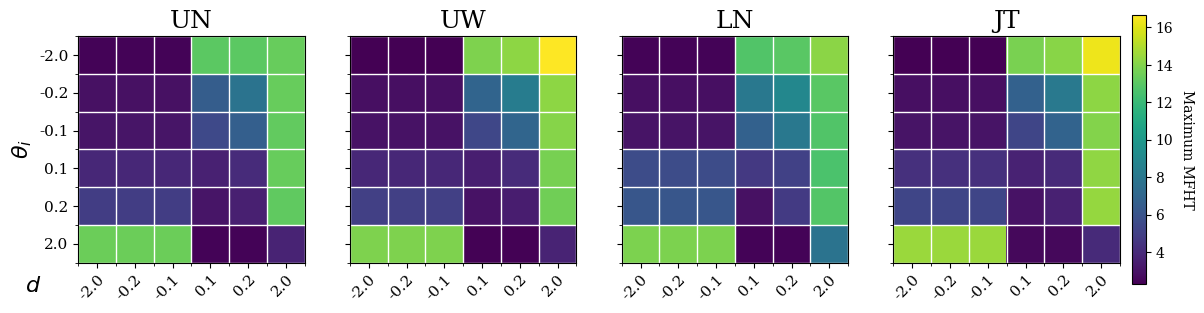

In [84]:
peaks = {market: get_max_values(market) for market in ["UN", "UW", "LN", "JT"]}
max_value, min_value = max(v.max() for v in peaks.values()), min(v.min() for v in peaks.values())
print(max_value, min_value)

fig, axs = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)

for market, ax in zip(MARKETS, axs.flatten()):
    ax, im = plot_mfht_peaks(market, peaks[market], min_value, max_value, ax, annotations=False)

# Add the y-axis and x-axis labels
axs[0].set_ylabel(r"$\theta_i$", fontsize=16)
axs[0].set_xlabel(r"$d$", fontsize=16, x=-0.2, labelpad=-20)

# Add a colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
cbar.set_label('Maximum MFHT', rotation=270, labelpad=15)

# fig.tight_layout()

plt.show()

In [ ]:
# fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.png', bbox_inches='tight')
# fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.eps', bbox_inches='tight')
# fig.savefig(f'../visualization/mfhts/max_MFHT_comparison.pdf', bbox_inches='tight')